In [435]:
# Common data analytics libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Scikit helper functions
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Scikit models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Optional: customise style of graphs
plt.style.use('seaborn-v0_8')

In [436]:
# Import our data in the form of a csv file
df = pd.read_csv(r"C:\Users\Alex\Downloads\Gr11 Science Fair\Malicious URLs.csv")
df

,URLs,Class
0,freebase.com/view/en/bob_sirois,good
1,en.wikipedia.org/wiki/Joie_Lee,good
2,pipl.com/directory/people/Rejean/Beaudin,good
3,flickr.com/photos/teneyck/sets/72157610336209297/,good
4,ussoccer.com/News/Federation-Services/2009/06/...,good
...,...,...
420459,ourorigins.org/genealogielistfirstname.aspx?an...,good
420460,simira.co.id/cifk/live.com/Account_Verified.htm,bad
420461,kstatesports.com/sports/w-baskbl/spec-rel/ksu-...,good
420462,vh1.com/video/living-colour/9128/cult-of-perso...,good


In [437]:
# Analyse our data
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420464 entries, 0 to 420463
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URLs    420464 non-null  object
 1   Class   420464 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


In [438]:
df.describe() # There are some duplicates which could create biase in our model

,URLs,Class
count,420464,420464
unique,411247,2
top,103.234.36.75/rd927.exe,good
freq,27,344821


In [439]:
df.isnull().sum() # Check for null values

URLs     0
Class    0
dtype: int64

In [440]:
df.nunique()

URLs     411247
Class         2
dtype: int64

In [441]:
df['Class'].value_counts()

Class
good    344821
bad      75643
Name: count, dtype: int64

In [442]:
df = df.drop_duplicates() # Remove duplicates
df = df.reset_index(drop=True) # Optional: reset the left index so that it properly counts the number of values
df

,URLs,Class
0,freebase.com/view/en/bob_sirois,good
1,en.wikipedia.org/wiki/Joie_Lee,good
2,pipl.com/directory/people/Rejean/Beaudin,good
3,flickr.com/photos/teneyck/sets/72157610336209297/,good
4,ussoccer.com/News/Federation-Services/2009/06/...,good
...,...,...
411243,ourorigins.org/genealogielistfirstname.aspx?an...,good
411244,simira.co.id/cifk/live.com/Account_Verified.htm,bad
411245,kstatesports.com/sports/w-baskbl/spec-rel/ksu-...,good
411246,vh1.com/video/living-colour/9128/cult-of-perso...,good


Text(0.5, 1.0, 'Fig 1. URL Database Distribution')

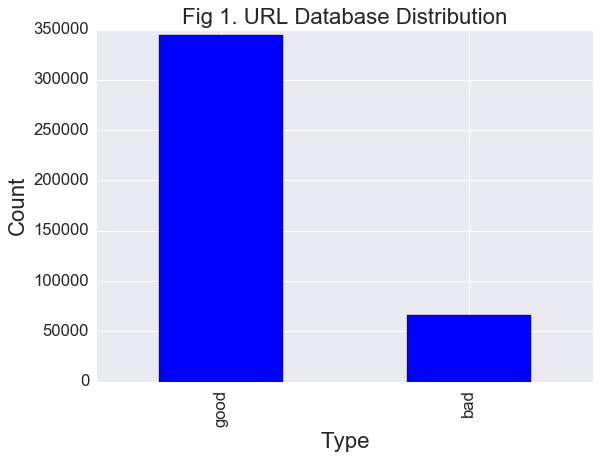

In [443]:
# Database visualisation
df['Class'].value_counts().plot(kind = 'bar', fontsize=15, color = 'Blue')
plt.xlabel("Type", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("Fig 1. URL Database Distribution", fontsize=20)

In [444]:
# Random url in database to test
test_url = df['URLs'][4]
test_url

'ussoccer.com/News/Federation-Services/2009/06/University-Of-Miami-President-Donna-E-Shalala-Joins-Team-To-Bring-FIFA-World-Cup-To-United-States-In.aspx'

In [445]:
# Split our training/test data
# 80% for training, 20% for testing
test_size_percentage = 0.2

# random_state sets a seed to the random generator, so that your train-test splits are always the same. If you don't set a seed, it will be different each time.
train_df, test_df = train_test_split(df, test_size = test_size_percentage, random_state=42) 

train_labels = train_df['Class']
test_labels = test_df['Class']

Text(0.5, 1.0, 'Training Data')

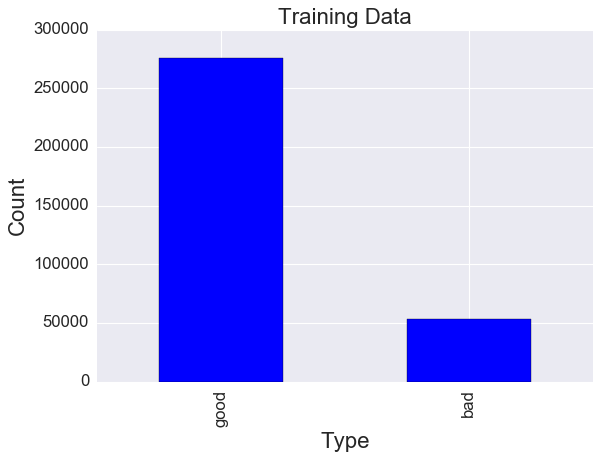

In [446]:
# Training data visualisation
train_labels.value_counts().plot(kind = 'bar', fontsize=15, color = 'Blue')
plt.xlabel("Type", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("Training Data", fontsize=20)

Text(0.5, 1.0, 'Testing Data')

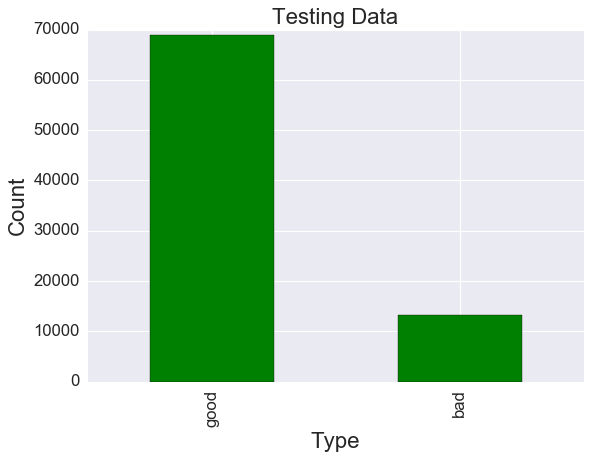

In [447]:
# Testing data visualisation
test_labels.value_counts().plot(kind = 'bar', fontsize=15, color = 'Green')
plt.xlabel("Type", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("Testing Data", fontsize=20)

In [448]:
def tokenizer(url):
  
  # Tokenization is the act of breaking a stream of input text into smaller pieces of strings called tokens.
  # The URL is then stripped down to the suitable format for pre-processing like removing unwanted punctuations or words
  
  # Split by slash (/) and dash (-)
  tokens = re.split('[/-]', url)
  
  for i in tokens:
    # Include the splits extensions and subdomains
    if i.find(".") >= 0:
      dot_split = i.split('.')
      
      # Remove .com and www. since they're too common
      if "com" in dot_split:
        dot_split.remove("com")
      if "www" in dot_split:
        dot_split.remove("www")
      
      tokens += dot_split
      
  return tokens # Returns the tokenized words; returned as a list

In [449]:
tokenized_url = tokenizer(test_url) # Testing our tokenizer function
tokenized_url

['ussoccer.com',
 'News',
 'Federation',
 'Services',
 '2009',
 '06',
 'University',
 'Of',
 'Miami',
 'President',
 'Donna',
 'E',
 'Shalala',
 'Joins',
 'Team',
 'To',
 'Bring',
 'FIFA',
 'World',
 'Cup',
 'To',
 'United',
 'States',
 'In.aspx',
 'ussoccer',
 'In',
 'aspx']

In [450]:
# Vectorisation of our training data
# The process of converting a raw string of inputs into a numerical representation that is stored in the form of a vector.

# Term Frequency-Inverse Document Frequency (TF-IDF)
tfidf_Vec = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None)
tfidf_X = tfidf_Vec.fit_transform(train_df['URLs'])

In [451]:
# Vectorisation of our testing data
test_count_X = count_Vec.transform(test_df['URLs'])
test_tfidf_X = tfidf_Vec.transform(test_df['URLs'])

In [452]:
# Define report generator

def generate_report(cmatrix, model, tableNum):
    # Generate confusion matrix heatmap
    plt.figure(figsize=(10, 10))
    
    # Extract confusion matrix values
    tn, fp, fn, tp = cmatrix.ravel()
    
    # Create a matrix of custom labels
    labels = [[f"True Negatives\n{tn}", f"False Positives\n{fp}"],
              [f"False Negatives\n{fn}", f"True Positives\n{tp}"]]
    
    sns.heatmap(cmatrix, 
                annot=labels, 
                fmt="",  # Empty because we're manually formatting annotations
                linewidths=0.5, 
                square=True, 
                cmap='Greens', 
                annot_kws={"size": 16}, 
                xticklabels=['Malicious', 'Benign'],
                yticklabels=['Malicious', 'Benign'])
    
    plt.xticks(rotation=0, fontsize=16)
    plt.yticks(rotation=0, fontsize=16)
    plt.xlabel('Actual', size=20)
    plt.ylabel('Prediction', size=20)
    
    title = f"{model}"
    plt.title("Table " + str(tableNum) + ": " + title, size=20)
    
    plt.show()

              precision    recall  f1-score   support

         bad       0.77      0.99      0.87     10339
        good       1.00      0.96      0.98     71911

    accuracy                           0.96     82250
   macro avg       0.89      0.98      0.92     82250
weighted avg       0.97      0.96      0.96     82250



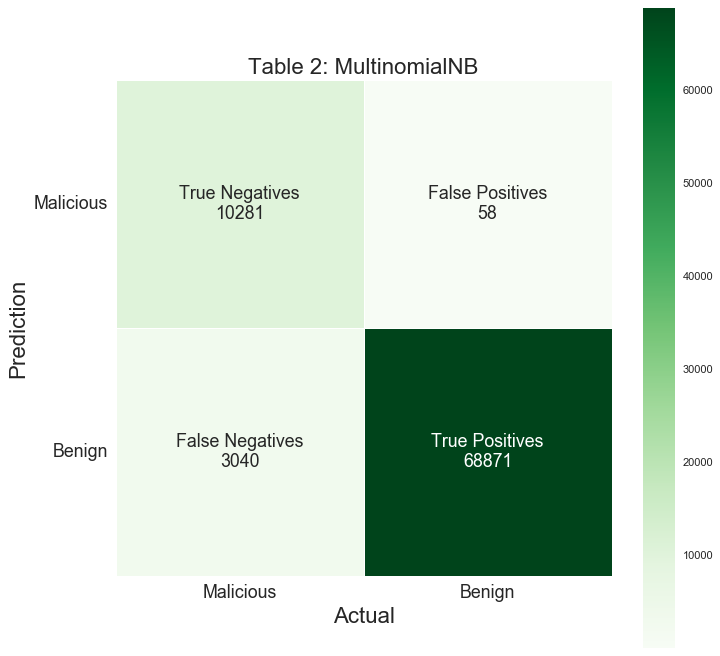

In [453]:
# Train the model
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(tfidf_X, train_labels)


# Test the mode (score, predictions, confusion matrix, classification report)
predictions_mnb_tfidf = mnb_tfidf.predict(test_tfidf_X)
cmatrix_mnb_tfidf = confusion_matrix(predictions_mnb_tfidf, test_labels)
creport_mnb_tfidf = classification_report(predictions_mnb_tfidf, test_labels)

# Create our matrix
print(creport_mnb_tfidf)
generate_report(cmatrix_mnb_tfidf, "MultinomialNB", 2)

              precision    recall  f1-score   support

         bad       0.81      0.95      0.88     11302
        good       0.99      0.96      0.98     70948

    accuracy                           0.96     82250
   macro avg       0.90      0.96      0.93     82250
weighted avg       0.97      0.96      0.96     82250



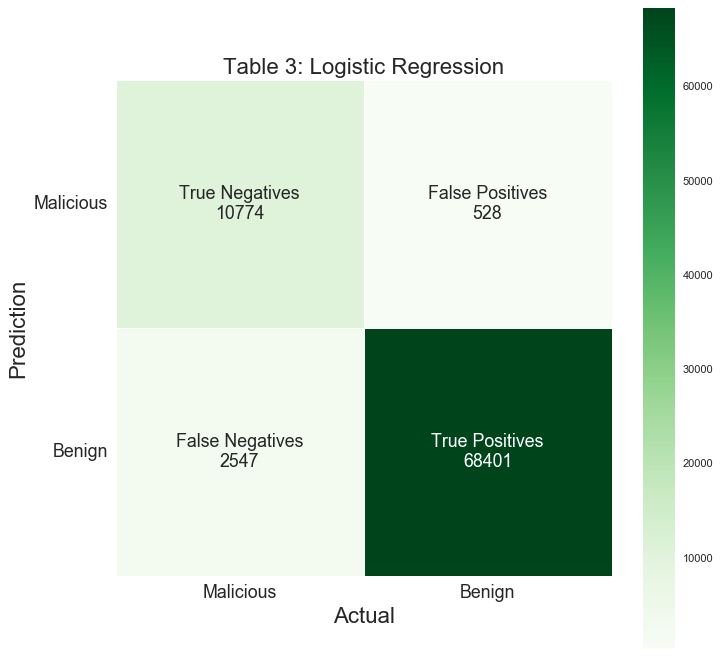

In [454]:
# Train the model
lgs_tfidf = LogisticRegression(solver='lbfgs')
lgs_tfidf.fit(tfidf_X, train_labels)


# Test the mode (score, predictions, confusion matrix, classification report)
predictions_lgs_tfidf = lgs_tfidf.predict(test_tfidf_X)
cmatrix_lgs_tfidf = confusion_matrix(predictions_lgs_tfidf, test_labels)
creport_lgs_tfidf = classification_report(predictions_lgs_tfidf, test_labels)

print(creport_lgs_tfidf)
generate_report(cmatrix_lgs_tfidf, "Logistic Regression", 3)